In [1]:
import LMRt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import mquantiles
import xarray as xr
from matplotlib import gridspec
from scipy.signal import find_peaks
import os

In [2]:
# data for IPCC AR5 Fig. 5.8b
# downloaded from http://store.pangaea.de/Publications/Masson-Delmotte_etal_2013/Fig5-8_data.zip

#Year ReconComp   Recon5%  Recon95% SimulComp   Simul5%  Simul95%
IPCC_data = np.array([
[  -5,    0.030,   -0.026,    0.086,    0.002,   -0.083,    0.087],
[  -4,   -0.040,   -0.094,    0.014,    0.017,   -0.039,    0.073],
[  -3,   -0.016,   -0.032,   -0.001,    0.017,   -0.045,    0.078],
[  -2,    0.021,   -0.025,    0.068,    0.019,   -0.036,    0.074],
[  -1,    0.005,   -0.037,    0.048,   -0.054,   -0.121,    0.013],
[   0,   -0.128,   -0.219,   -0.037,   -0.284,   -0.483,   -0.085],
[   1,   -0.167,   -0.292,   -0.042,   -0.264,   -0.516,   -0.012],
[   2,   -0.155,   -0.294,   -0.016,   -0.214,   -0.447,    0.019],
[   3,   -0.121,   -0.272,    0.029,   -0.141,   -0.318,    0.037],
[   4,   -0.098,   -0.254,    0.058,   -0.076,   -0.238,    0.087],
[   5,   -0.084,   -0.244,    0.076,   -0.029,   -0.182,    0.124],
[   6,   -0.085,   -0.228,    0.058,   -0.002,   -0.135,    0.132],
[   7,   -0.053,   -0.142,    0.036,    0.035,   -0.080,    0.150],
[   8,   -0.059,   -0.150,    0.031,    0.030,   -0.079,    0.139],
[   9,   -0.062,   -0.183,    0.060,    0.010,   -0.089,    0.110],
[  10,   -0.034,   -0.186,    0.118,    0.024,   -0.094,    0.141]])

In [3]:
# SEA on GCM simulations

GCM_namelist = ['bcc', 'GISS', 'HadCM3', 'IPSL', 'MIROC', 'MPI-ESM-P', 'CSIRO', 'CCSM4', 'iCESM', 'CESM-LME']

events_G08 = [1600, 1641, 1673, 1693, 1815, 1835] 
sea_nhmt = {}
for sim_name in GCM_namelist:
    with open(f'../data/gcm_sims/nhmt_{sim_name}.pkl', 'rb') as f:
        nhmt, year = pickle.load(f)
        
    sea_nhmt[sim_name] = LMRt.utils.sea(
        nhmt, events_G08, preyr=5, postyr=10, start_yr=year[0]
    )

GCM_composites = np.ndarray((len(GCM_namelist), np.size(sea_nhmt['iCESM']['composite_yr'])))
for i, GCM_tag in enumerate(GCM_namelist):
    GCM_composites[i] = sea_nhmt[GCM_tag]['composite']
    
GCM_qs = mquantiles(GCM_composites, [0.05, 0.5, 0.95], axis=0)

sea_GCMs_composite = sea_nhmt['iCESM'].copy()
sea_GCMs_composite['composite'] = GCM_qs[1]  # median
sea_GCMs_composite['composite_qs'] = GCM_qs  # quantiles

In [4]:
# SEA on LMR reconstructions

events_eVolv2k = np.array([1600, 1640, 1673, 1695, 1815, 1835])

LMR_namelist = [
    'pages2k',
    'pages2k.tree',
    'pages2k.tree.trw',
    'pages2k.tree.mxd',
]

sea_lmr = {}
for exp_tag in LMR_namelist:
    with open(f'../data/lmr_recons/nhmt_LMRt_{exp_tag}_ann.pkl', 'rb') as f:
        nhmt, to = pickle.load(f)
    
    sea_lmr[exp_tag] = LMRt.utils.sea(nhmt, events_eVolv2k, preyr=5, postyr=10, verbose=False)

In [5]:
# load volcanic forcing data

df = pd.read_csv('../data/volc_forcing/IVI2TotalInjection_501-2000Version2.txt', skiprows=12, sep='\s+', names=['Year', 'NH', 'SH', 'Global'])
year = df['Year'].values
global_injection = df['Global'].values

with xr.open_dataset('../data/volc_forcing/eVolv2k_v3_ds_1.nc') as ds:
    yearCE = ds['yearCE']
    vssi = ds['vssi'].values
    sigma_vssi = ds['sigma_vssi'].values

start_yr, end_yr = 1400, 1900

global_injection[np.isnan(global_injection)] = 0
mask = (year>=start_yr) & (year<=end_yr)

vssi[np.isnan(vssi)] = 0
mask = (yearCE>=start_yr) & (yearCE<=end_yr)

df_merge = pd.DataFrame({'Year': year, 'VSSI_G08': global_injection})
frame = pd.DataFrame({'Year': yearCE, 'VSSI_eVolv2k': vssi})

df_merge = df_merge.merge(frame, how='outer', on='Year')
df_merge.set_index('Year', drop=True, inplace=True)
df_merge.sort_index(inplace=True)
df_merge.astype(np.float)

df_merge = df_merge[(df_merge.index>=start_yr) & (df_merge.index<=end_yr)].fillna(0)

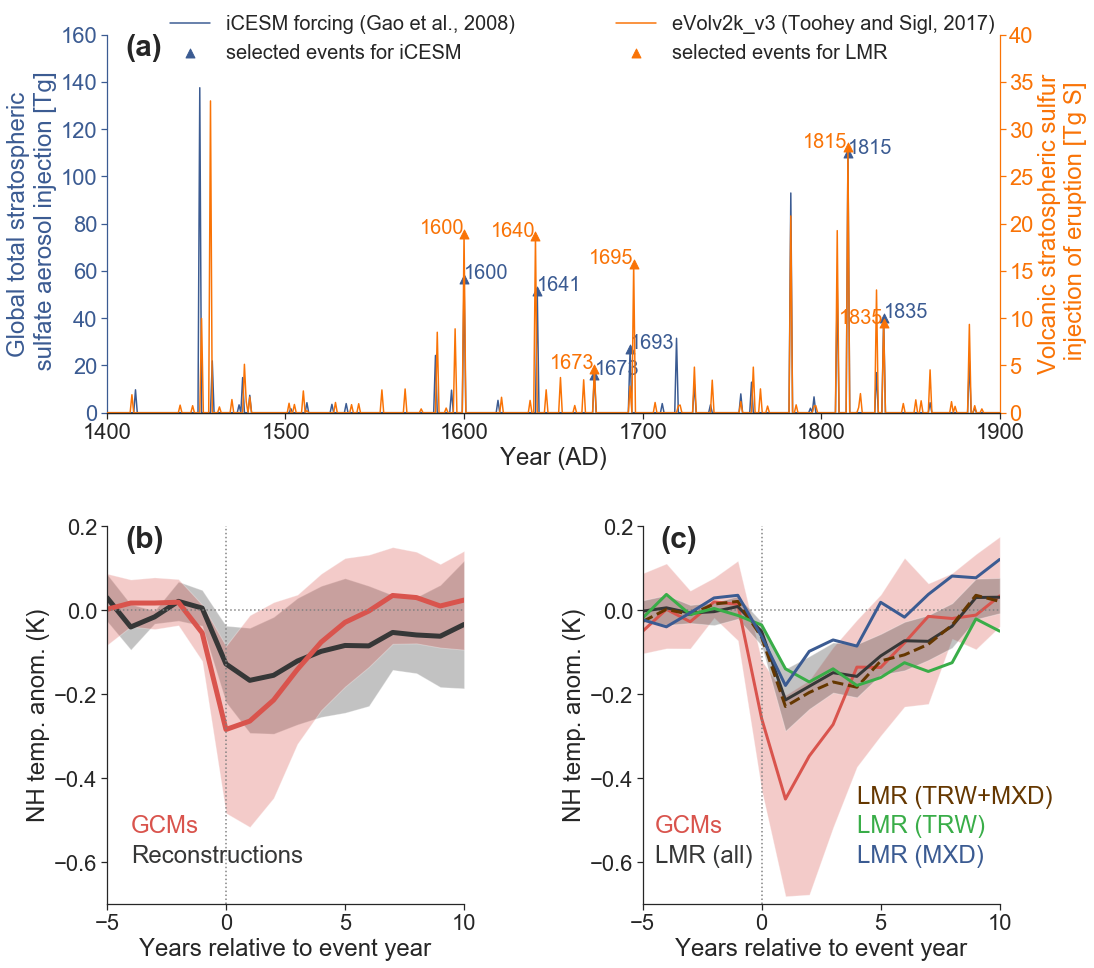

In [6]:
# plot Fig.1

clr_G08 = sns.xkcd_rgb['denim blue']
clr_eVolv2k = sns.xkcd_rgb['orange']
sns.set(style='ticks', font_scale=2)
fig = plt.figure(figsize=[16, 16])

ylim = [-0.7, 0.2]

gs = gridspec.GridSpec(2, 2)                                                                                                                                                       
gs.update(wspace=0.5, hspace=0.3)
           
ax1 = plt.subplot(gs[0, 0:2])
ax1.plot(df_merge.index, df_merge['VSSI_G08'], label='iCESM forcing (Gao et al., 2008)', color=clr_G08)

ax1.set_xlabel('Year (AD)')
ax1.set_ylabel('Global total stratospheric\n sulfate aerosol injection [Tg]', color=clr_G08)

peaks_G08, _ = find_peaks(df_merge['VSSI_G08'], height=1.)
peaks_eVolv2k, _ = find_peaks(df_merge['VSSI_eVolv2k'], height=4)

events_G08_idx = [list(df_merge.index.values).index(e) for e in events_G08]
ax1.scatter(events_G08, df_merge['VSSI_G08'].values[events_G08_idx],
           marker='^', s=80, color=clr_G08, label='selected events for iCESM')

fs = 20
for i, e in enumerate(events_G08):
    ax1.text(e, df_merge['VSSI_G08'].values[events_G08_idx][i], e,
            color=clr_G08, fontsize=fs, zorder=99)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(df_merge.index, df_merge['VSSI_eVolv2k'], label='eVolv2k_v3 (Toohey and Sigl, 2017)', color=clr_eVolv2k)
ax2.set_ylabel('Volcanic stratospheric sulfur\n injection of eruption [Tg S]', color=clr_eVolv2k)

events_eVolv2k_idx = [list(df_merge.index.values).index(e) for e in events_eVolv2k]
ax2.scatter(events_eVolv2k, df_merge['VSSI_eVolv2k'].values[events_eVolv2k_idx],
           marker='^', s=80, color=clr_eVolv2k, label='selected events for LMR')
for i, e in enumerate(events_eVolv2k):
    ax2.text(e-25, df_merge['VSSI_eVolv2k'].values[events_eVolv2k_idx][i], e,
            color=clr_eVolv2k, fontsize=fs, zorder=99)
    
ax1.set_ylim([0, 160])
ax1.set_xlim([1400, 1900])
ax2.set_ylim([0, 40])

ax1.spines['right'].set_visible(False)                                                                                                                                      
ax1.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)                                                                                                                                      
ax2.spines['top'].set_visible(False)

ax1.spines['left'].set_color(clr_G08) 
ax2.spines['right'].set_color(clr_eVolv2k) 
ax1.tick_params(axis='y', colors=clr_G08) 
ax2.tick_params(axis='y', colors=clr_eVolv2k) 

ax1.legend(frameon=False, ncol=1, loc='upper left', bbox_to_anchor=[0.05, 1.1], fontsize=20)
ax2.legend(frameon=False, ncol=1, loc='upper left', bbox_to_anchor=[0.55, 1.1], fontsize=20)
LMRt.visual.setlabel(ax2, '(a)', prop={'weight': 'bold', 'size': 30}, bbox_to_anchor=[0, 1.05])
#=======================================================
alpha = 0.3
ax3 = plt.subplot(gs[1, 0])
ax3.plot(IPCC_data[:, 0], IPCC_data[:, 1], color=sns.xkcd_rgb['dark grey'], lw=5)
ax3.fill_between(IPCC_data[:, 0], IPCC_data[:, 2], IPCC_data[:, 3], facecolor=sns.xkcd_rgb['dark grey'], alpha=alpha)
ax3.plot(IPCC_data[:, 0], IPCC_data[:, 4], color=sns.xkcd_rgb['pale red'], lw=5)
ax3.fill_between(IPCC_data[:, 0], IPCC_data[:, 5], IPCC_data[:, 6], facecolor=sns.xkcd_rgb['pale red'], alpha=alpha)
ax3.set_ylabel('NH temp. anom. (K)')                                                                                                                                                          
ax3.set_xlabel('Years relative to event year')                                                                                                                                         
ax3.axvline(x=0, ls=':', color='grey')                                                                                                                                                 
ax3.axhline(y=0, ls=':', color='grey')                                                                                                                                                 
ax3.spines['right'].set_visible(False)                                                                                                                                                 
ax3.spines['top'].set_visible(False)
ax3.set_ylim(ylim)
ax3.set_xlim([-5, 10])
ax3.text(-4, -0.53, 'GCMs', color=sns.xkcd_rgb['pale red'])
ax3.text(-4, -0.6, 'Reconstructions', color=sns.xkcd_rgb['dark grey'])

LMRt.visual.setlabel(ax3, '(b)', prop={'weight': 'bold', 'size': 30}, bbox_to_anchor=[0, 1.05])
#=======================================================
exp_dict = {
    'pages2k': {'clr': sns.xkcd_rgb['dark grey'], 'lb': 'LMR (pages2k)', 'ls': '-'},
    'pages2k.tree': {'clr': sns.xkcd_rgb['brown'], 'lb': 'LMR (pages2k.tree)', 'ls': '--'},
    'pages2k.tree.trw': {'clr': sns.xkcd_rgb['medium green'], 'lb': 'LMR (pages2k.tree.trw)', 'ls': '-'},
    'pages2k.tree.mxd': {'clr': sns.xkcd_rgb['denim blue'], 'lb': 'LMR (pages2k.tree.mxd)', 'ls': '-'},
}

alpha = 0.3
ax4 = plt.subplot(gs[1, 1])
LMRt.visual.plot_sea_res(sea_GCMs_composite, color=sns.xkcd_rgb['pale red'], xticks=[-5, 0, 5, 10],
                         ls='-', label='GCMs', shade_alpha=alpha, fig=fig, ax=ax4, ylabel='NH temp. anom. (K)')

sea_res = {}
for exp_name, style_dict in exp_dict.items():
    ax4.plot(sea_lmr[exp_name]['composite_yr'], sea_lmr[exp_name]['composite_qs'][1], ls=style_dict['ls'],
            label=style_dict['lb'], lw=3, color=style_dict['clr'])
    if exp_name == 'pages2k':
        ax4.fill_between(sea_lmr[exp_name]['composite_yr'], sea_lmr[exp_name]['composite_qs'][0], sea_lmr[exp_name]['composite_qs'][-1],
                facecolor=style_dict['clr'], alpha=alpha)
    ax4.set_ylim(ylim)
    ax4.set_xlim([-5, 10])
    
ax4.text(-4.5, -0.53, 'GCMs', color=sns.xkcd_rgb['pale red'])
ax4.text(-4.5, -0.6, 'LMR (all)', color=sns.xkcd_rgb['dark grey'])
ax4.text(4, -0.46, 'LMR (TRW+MXD)', color=sns.xkcd_rgb['brown'])
ax4.text(4, -0.53, 'LMR (TRW)', color=sns.xkcd_rgb['medium green'])
ax4.text(4, -0.6, 'LMR (MXD)', color=sns.xkcd_rgb['denim blue'])

LMRt.visual.setlabel(ax4, '(c)', prop={'weight': 'bold', 'size': 30}, bbox_to_anchor=[0, 1.05])

#======================================================================
fig.savefig('../figs/Fig-1.pdf', bbox_inches='tight')